In [ ]:
Credit risk analysis  by using following 3 Algorithms and then
we'll compare their performance after applying cost-sensitive learning because not all algorithms respond same to cost sensitive learning

Algorithms
Logistic regression
Random forests
XGBoost


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.encoding import (
    RareLabelEncoder, 
    OrdinalEncoder, 
    OneHotEncoder,
)
from feature_engine.imputation import (
    ArbitraryNumberImputer, 
    CategoricalImputer, 
    MeanMedianImputer, 
    AddMissingIndicator,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    TunedThresholdClassifierCV,
)
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    balanced_accuracy_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [10]:
df = pd.read_csv("C:\\Users\\dipsa\\Downloads\\cv new sayanti\\python project\\ML_Jupyter_2024\\LoanData_Bondora.csv").sample(10000)

df.head()

,new_customer,income_verification,language,age,gender,country,amount,loan_duration,use_of_loan,education,...,credit_score_microL,credit_score_equifax,credit_score_fi_asiakas,credit_score_ee_mini,nr_previous_loans,amount_previous_loans,previous_repayments,previous_early_repayments,previous_early_repayments_count,default
39337,0,expenses_verified,estonian,41,male,EE,530.0,36,unknown,vocational,...,M,NaN,NaN,1000.0,5.0,8380.0,686.36,NaN,0.0,0
33006,0,expenses_verified,estonian,59,male,EE,2125.0,24,unknown,secondary,...,M,NaN,NaN,1000.0,7.0,10610.0,548.90,NaN,0.0,0
78678,0,expenses_verified,russian,28,male,EE,1169.0,24,unknown,primary,...,M,NaN,NaN,600.0,1.0,1275.0,1126.05,NaN,0.0,0
114081,1,expenses_verified,finnish,38,male,FI,4250.0,60,unknown,vocational,...,M,NaN,4,NaN,0.0,0.0,NaN,NaN,0.0,1
66953,1,expenses_verified,finnish,49,female,FI,3113.0,60,unknown,higher,...,M,NaN,3.0,NaN,0.0,0.0,NaN,NaN,0.0,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("default", axis=1),
    df["default"],
    test_size=0.10,
    random_state=10,
)

X_train.shape, X_test.shape

((9000, 31), (1000, 31))

In [14]:
# Calculate the default rate in each data set

y_train.mean(), y_test.mean()

(np.float64(0.08055555555555556), np.float64(0.096))

In [ ]:
#For logistic regression we'll impute with the mean and add missing indicators. For tree based models we'll impute with an arbitrary number.

#For logistic regression we'll do one hot encoding, for tree based models, we'll carry out ordinal encoding.

In [15]:
numerical_vars = [c for c in X_train.columns if df[c].dtype != "O"]


In [16]:
# set up individual feature engineering steps

missing_indicators = AddMissingIndicator(variables=numerical_vars)

imputer_mean = MeanMedianImputer()
imputer_arbitrary = ArbitraryNumberImputer(arbitrary_number=-1)
imputer_categorical = CategoricalImputer()

rare_encoder = RareLabelEncoder(n_categories=2)
ordinal = OrdinalEncoder(encoding_method="arbitrary")
onehot = OneHotEncoder(drop_last=True)

In [17]:
#set up pipeline without cost sensitive learning
logit = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(
        penalty = 'l2',
        C = 0.1, 
        random_state=10),
    ),
]).set_output(transform="pandas")


rf = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(
        n_estimators = 100,
        max_depth = 4, 
        random_state=10),
    )
]).set_output(transform="pandas")


xgb = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(
        n_estimators = 100,
        max_depth =  4,
        random_state=10),
    )
]).set_output(transform="pandas")

In [18]:
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=10, ...))])

In [19]:
logit_csl = Pipeline([
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("missing_indicators", missing_indicators),
    ("imputer_num", imputer_mean),
    ("encoder", onehot),
    ("model", LogisticRegression(
        penalty = 'l2',
        C = 0.1,
        class_weight = {0:1, 1:10},
        random_state=10),
    ),
]).set_output(transform="pandas")


rf_csl = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", RandomForestClassifier(
        n_estimators = 100,
        max_depth = 4,
        class_weight = {0:1, 1:10},
        random_state=10),
    )
]).set_output(transform="pandas")


xgb_csl = Pipeline([
    ("imputer_num", imputer_arbitrary),
    ("imputer_cat", imputer_categorical),
    ("rare_categories", rare_encoder),
    ("encoder", ordinal),
    ("model", XGBClassifier(
         n_estimators = 100,
        max_depth =  4,
        random_state=10),
    )
]).set_output(transform="pandas")

In [20]:
#now run pipeline with cost sensitive learning
logit_csl.fit(X_train, y_train)
rf_csl.fit(X_train, y_train)

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=4,
                                        random_state=10))])

In [21]:
# fit with sample weights

xgb_csl.fit(X_train, y_train, model__sample_weight=np.where(y_train==1,10,1))

Pipeline(steps=[('imputer_num', ArbitraryNumberImputer(arbitrary_number=-1)),
                ('imputer_cat', CategoricalImputer()),
                ('rare_categories', RareLabelEncoder(n_categories=2)),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=10, ...))])

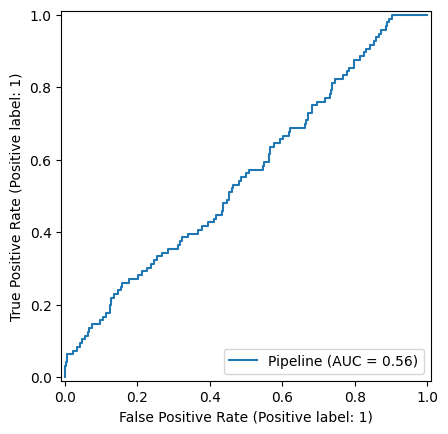

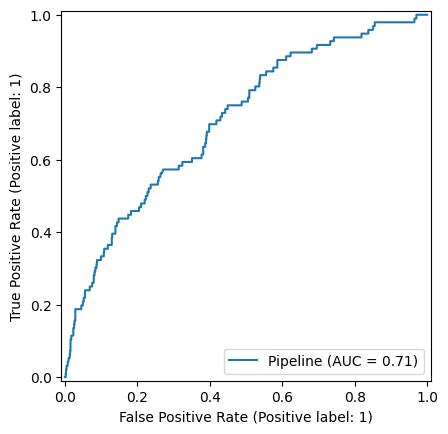

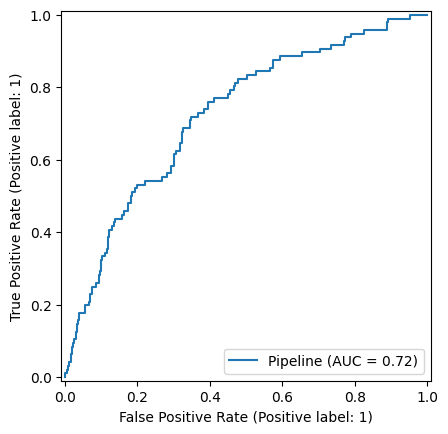

In [22]:
logit_roc = RocCurveDisplay.from_estimator(logit, X_test, y_test)
rf_roc = RocCurveDisplay.from_estimator(rf, X_test, y_test)
xgb_roc = RocCurveDisplay.from_estimator(xgb, X_test, y_test)

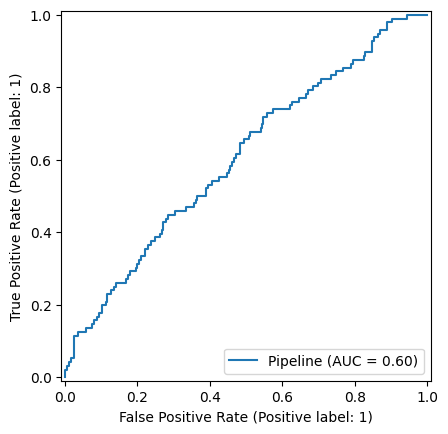

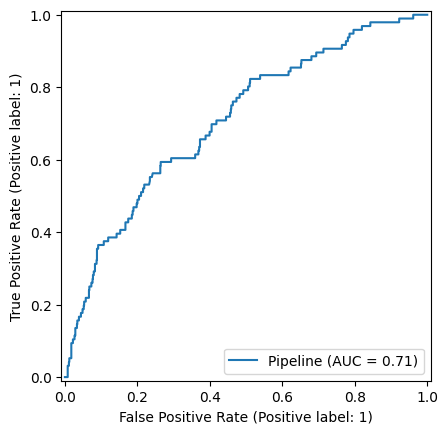

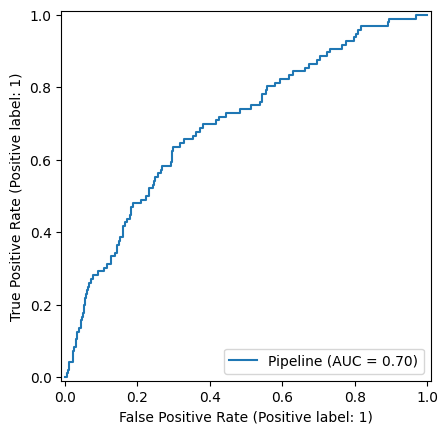

In [23]:
logit_csl_roc = RocCurveDisplay.from_estimator(logit_csl, X_test, y_test)
rf_csl_roc = RocCurveDisplay.from_estimator(rf_csl, X_test, y_test)
xgb_csl_roc = RocCurveDisplay.from_estimator(xgb_csl, X_test, y_test)

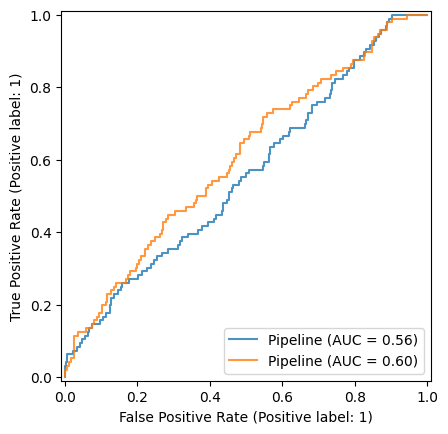

In [28]:
ax = plt.gca()
logit_roc.plot(ax=ax, alpha=0.8)
logit_csl_roc.plot(ax=ax, alpha=0.8)

In [ ]:
#Above diagram shows ROC-AUC metric got improved by cost sensitive model compared to normal model for Logistic Regression

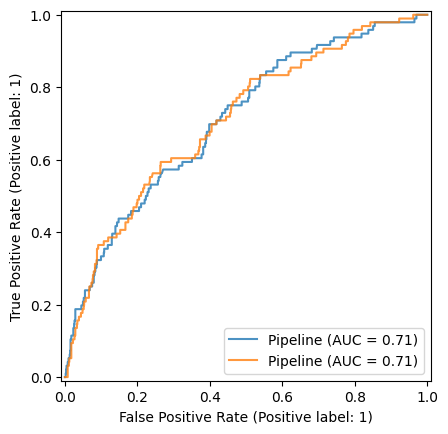

In [29]:
ax = plt.gca()
rf_roc.plot(ax=ax, alpha=0.8)
rf_csl_roc.plot(ax=ax, alpha=0.8)

In [ ]:
#Above diagram shows ROC-AUC metric did not  improved by cost sensitive model compared to normal model for Random Forest Algorithm

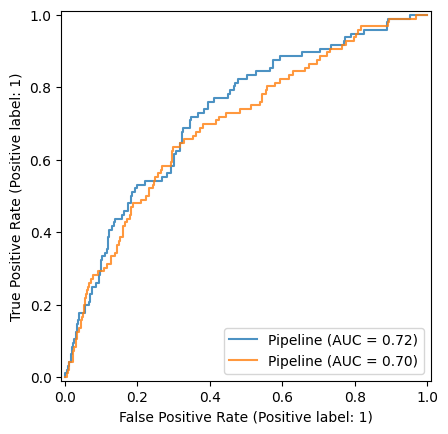

In [30]:
ax = plt.gca()
xgb_roc.plot(ax=ax, alpha=0.8)
xgb_csl_roc.plot(ax=ax, alpha=0.8)

In [ ]:
#Above diagram shows ROC-AUC metric did not  improve, infact it decreased ROC-AUC by cost sensitive model compared to normal model for XGBoost Algorithm

In [ ]:
#Precision and Recall curve for all 3 algorithms

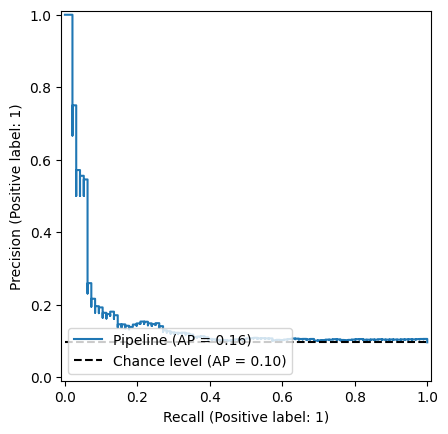

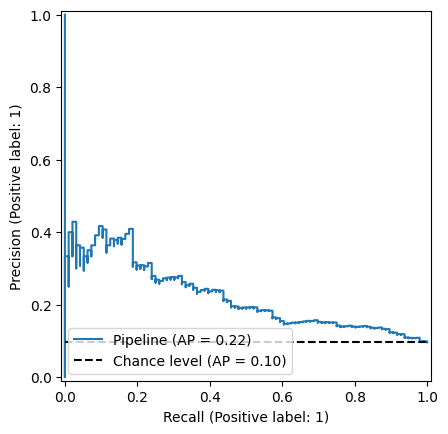

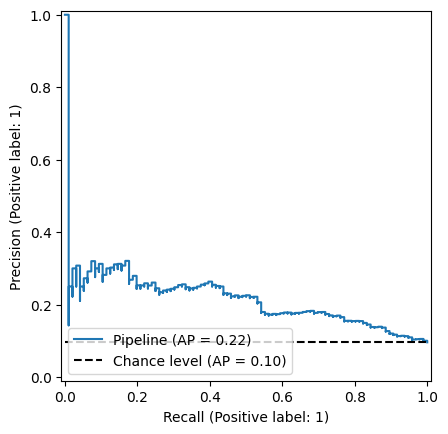

In [31]:
logit_prc = PrecisionRecallDisplay.from_estimator(logit, X_test, y_test, plot_chance_level=True)
rf_prc = PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, plot_chance_level=True)
xgb_prc = PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test, plot_chance_level=True)

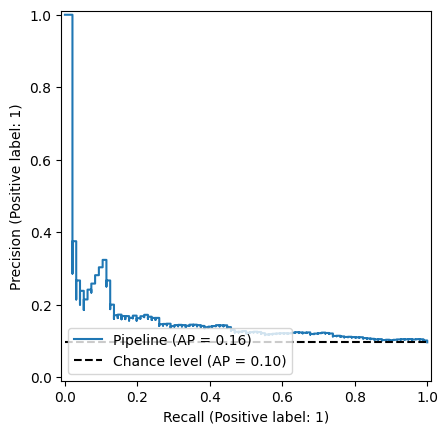

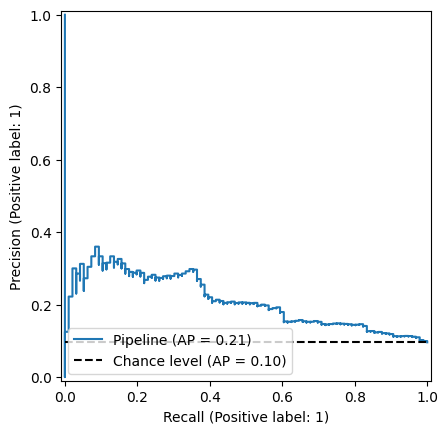

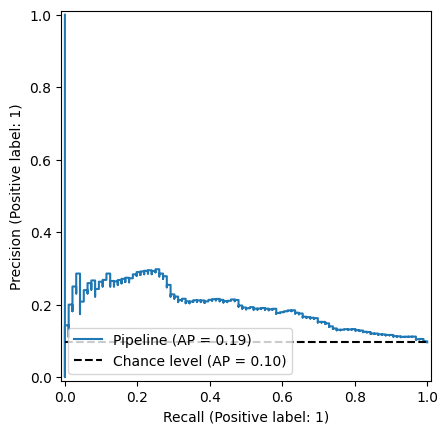

In [32]:
logit_csl_prc = PrecisionRecallDisplay.from_estimator(logit_csl, X_test, y_test, plot_chance_level=True)
rf_csl_prc = PrecisionRecallDisplay.from_estimator(rf_csl, X_test, y_test, plot_chance_level=True)
xgb_csl_prc = PrecisionRecallDisplay.from_estimator(xgb_csl, X_test, y_test, plot_chance_level=True)

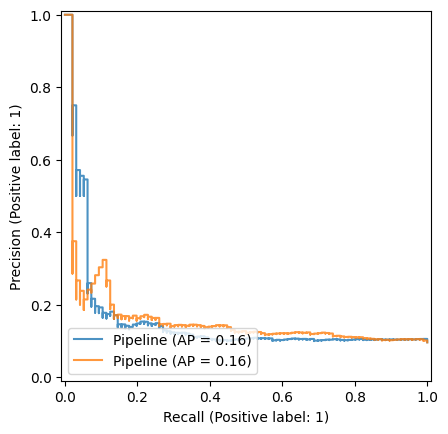

In [33]:
ax = plt.gca()
logit_prc.plot(ax=ax, alpha=0.8)
logit_csl_prc.plot(ax=ax, alpha=0.8)

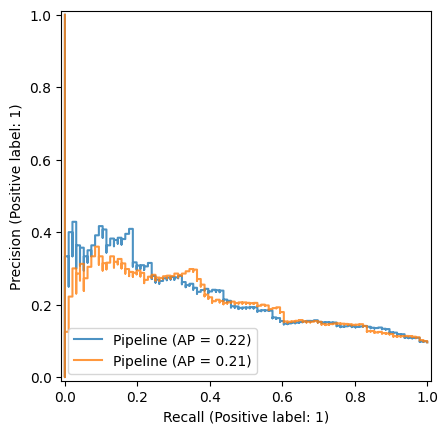

In [34]:
ax = plt.gca()
rf_prc.plot(ax=ax, alpha=0.8)
rf_csl_prc.plot(ax=ax, alpha=0.8)

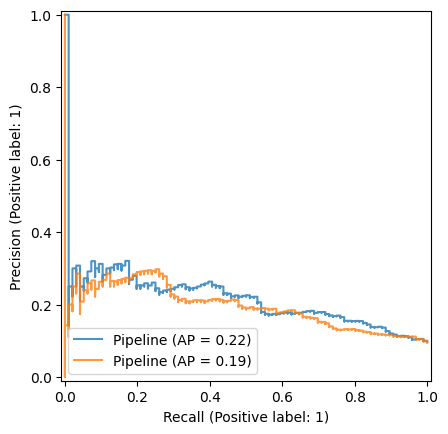

In [35]:
ax = plt.gca()
xgb_prc.plot(ax=ax, alpha=0.8)
xgb_csl_prc.plot(ax=ax, alpha=0.8)

In [ ]:
#Above precision recall curves show that cost sensitive training has failed to improve precision/recall for all 3 algorithms